<a href="https://colab.research.google.com/github/sthalles/SimCLR/blob/simclr-refactor/feature_eval/mini_batch_logistic_regression_evaluator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import torch
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [83]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
from torch import optim
import torch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [48]:
def load_embeddings(path):
    h_file = h5py.File(path, 'r')
    Xi = h_file['/']['image_embeds'].value
    Xt = h_file['/']['text_embeds'].value
    Y = h_file['/']['labels_embeds'].value
    h_file.close()
    return Xi, Xt, Y

In [49]:
Xi, Xt, Y = load_embeddings('/home/khizirs/contr/hatefulmemes/multimodal/runs/Jun18_23-48-51_LS121/embeds-tsne-25.h5')
Xi.shape, Xt.shape, Y.shape

((8352, 2), (8352, 2), (8352,))

In [51]:
X = np.concatenate((Xi, Xt), axis=-1)
X.shape

(8352, 4)

In [108]:
class Net(nn.Module):
    def __init__(self, in_dims = 4, h_dims=4, n_classes=2):
        super().__init__()
        self.l1 = nn.Linear(in_dims, h_dims)
        self.nl = nn.ReLU()
        self.l2 = nn.Linear(h_dims, n_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.nl(out)
        out = self.l2(out)
        return out

model = Net()
model.to(device)

Net(
  (l1): Linear(in_features=4, out_features=4, bias=True)
  (nl): ReLU()
  (l2): Linear(in_features=4, out_features=2, bias=True)
)

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((6681, 4), (6681,), (1671, 4), (1671,))

In [72]:
(Y_test==1).sum(), (Y_test==0).sum()

(599, 1072)

In [109]:
class MyData(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

BS = 128
    
trainset = MyData(X_train, Y_train)
testset = MyData(X_test, Y_test)
trainloader = DataLoader(trainset, batch_size=BS, num_workers=4)
testloader = DataLoader(testset, batch_size=BS, num_workers=4)

In [110]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)
num_epochs = 10

In [111]:
train_accuracies = []
val_accuracies = []
for epoch in range(1, num_epochs+1):
    train_losses = []
    correct = 0
    total_preds = []
    total_true = []
    for feats, labels in trainloader:
        feats, labels = feats.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(feats)
        preds = torch.argmax(out, -1)
        correct += (preds == labels).int().sum().item()
        total_preds.append(preds.cpu().detach().numpy())
        total_true.append(labels.cpu().detach().numpy())
        loss = criterion(out, labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    train_accuracies.append(correct / len(trainset))
    total_preds = np.concatenate(total_preds)
    total_true = np.concatenate(total_true)
    train_cm = confusion_matrix(total_true, total_preds)
    train_f1 = f1_score(total_true, total_preds)
    
    val_losses = []
    pcorrect = 0
    total_preds = []
    total_true = []
    with torch.no_grad():
        for feats, labels in testloader:
            feats, labels = feats.to(device), labels.to(device)
            out = model(feats)
            preds = torch.argmax(out, -1)
            pcorrect += (preds == labels).int().sum().item()
            total_preds.append(preds.cpu().detach().numpy())
            total_true.append(labels.cpu().detach().numpy())
            loss = criterion(out, labels)
            val_losses.append(loss.item())
    val_accuracies.append(pcorrect / len(testset))
    total_preds = np.concatenate(total_preds)
    total_true = np.concatenate(total_true)
    val_cm = confusion_matrix(total_true, total_preds)
    val_f1 = f1_score(total_true, total_preds)
    
    print(f"[ {epoch} ]: Train Accuracy: {train_accuracies[-1]}\tValidation Accuracy: {val_accuracies[-1]}")
    print(f"[   ]: Train F1: {train_f1}\t\tValidation F1: {val_f1}")
print("Complete")

[ 1 ]: Train Accuracy: 0.45142942673252506	Validation Accuracy: 0.47277079593058047
[   ]: Train F1: 0.3945151164711714		Validation F1: 0.3410620792819746
[ 2 ]: Train Accuracy: 0.5002245172878311	Validation Accuracy: 0.5110712148414124
[   ]: Train F1: 0.35478260869565226		Validation F1: 0.3510722795869738
[ 3 ]: Train Accuracy: 0.5306091902409819	Validation Accuracy: 0.5433871932974267
[   ]: Train F1: 0.3386756642766765		Validation F1: 0.3057324840764331
[ 4 ]: Train Accuracy: 0.5603951504265828	Validation Accuracy: 0.5715140634350688
[   ]: Train F1: 0.30649350649350643		Validation F1: 0.2767676767676767
[ 5 ]: Train Accuracy: 0.5795539589881754	Validation Accuracy: 0.582884500299222
[   ]: Train F1: 0.26715366553613357		Validation F1: 0.2481121898597627
[ 6 ]: Train Accuracy: 0.596018560095794	Validation Accuracy: 0.6008378216636745
[   ]: Train F1: 0.244189302716326		Validation F1: 0.22531939605110335
[ 7 ]: Train Accuracy: 0.6069450681035773	Validation Accuracy: 0.61101137043686

In [112]:
def plot_confusion_matrix(cm, class_names):
        """
        Returns a matplotlib figure containing the plotted confusion matrix.
        
        Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
        """
        import itertools
        
        figure = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)
        
        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.
        
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
            
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return figure

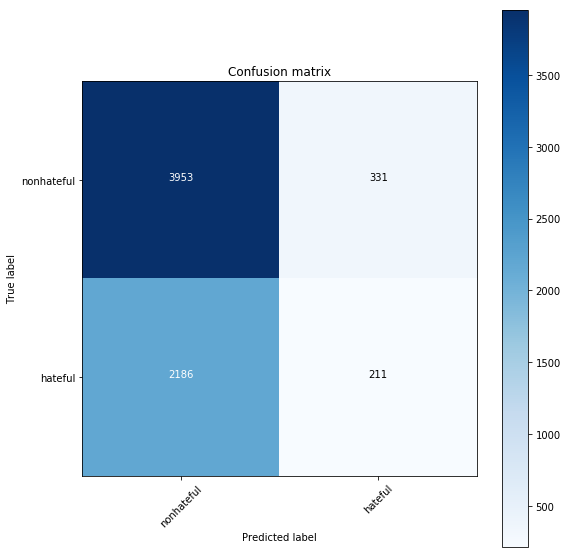

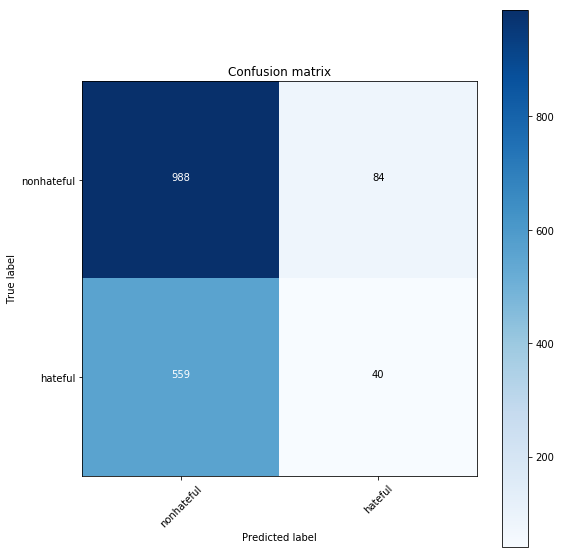

In [113]:
train_conf = plot_confusion_matrix(train_cm, ['nonhateful', 'hateful'])
train_conf.show()
val_conf = plot_confusion_matrix(val_cm, ['nonhateful', 'hateful'])
train_conf.show()

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

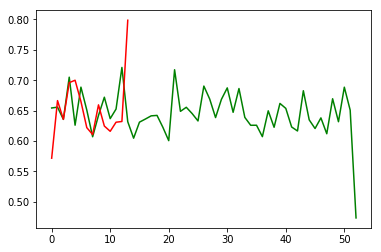

In [104]:
plt.plot(train_losses, c='g')
plt.plot(val_losses, c='r')
plt.show()

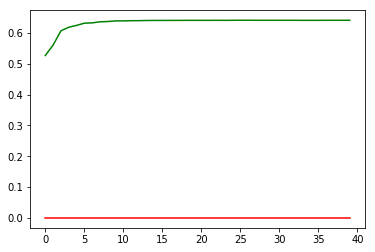

In [106]:
plt.plot(train_accuracies, c='g')
plt.plot(val_accuracies, c='r')
plt.show()